In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from unbalanced_cv import get_fold
from sklearn.neural_network import MLPClassifier

import networkx as nx
import data_analysis_func as func

#colorize images
import misc
import data_analysis_func as func

# Parameters

In [2]:
#"Properties Index" - Properties to be validated
# [1 = Shapes], [2 = Network], [3 = All], [4 - All and Idx], [5 = Degree]

r = 350                                # Radius to be analized
k = 3                                  # Number of neighbors for the k-nearest neighbors classifier
number_classes = 2                     # Number of classes in the dataset
number_folds = 5                       # Number of Folds

erode = False
dilate = False
dilate_no_merge = False
remove_randomly = False

x_iterations = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

if not erode and not dilate and not dilate_no_merge and not remove_randomly:
    image_names = ['3', 
                   'S07_40805_upper_10X_Snapshot_20151028_54_region_01', 
                   'S07_41755_upper_10X_Snapshot_20151028_44_region_02', 
                   'S07_41755_upper_10X_Snapshot_20151028_44_region_03', 
                   'S07_41755_upper_10X_Snapshot_20151028_44_region_04', 
                   'S07_42991_lower_10X_Snapshot_20151028_47_region_08', 
                   'S07_46186 10X_20151028_59']

if erode:
    image_names = ['S07_46186 10X_20151028_59',
                   'S07_46186 10X_20151028_59_EROSION_IT1', 
                   'S07_46186 10X_20151028_59_EROSION_IT3', 
                   'S07_46186 10X_20151028_59_EROSION_IT5', 
                   'S07_46186 10X_20151028_59_EROSION_IT7', 
                   'S07_46186 10X_20151028_59_EROSION_IT9', 
                   'S07_46186 10X_20151028_59_EROSION_IT11',
                   'S07_46186 10X_20151028_59_EROSION_IT13',
                   'S07_46186 10X_20151028_59_EROSION_IT15',
                   'S07_46186 10X_20151028_59_EROSION_IT17',
                   'S07_46186 10X_20151028_59_EROSION_IT19',
                   'S07_46186 10X_20151028_59_EROSION_IT21']

if dilate:
    image_names = ['S07_46186 10X_20151028_59',
                   'S07_46186 10X_20151028_59_DILATION_IT1',
                   'S07_46186 10X_20151028_59_DILATION_IT3',
                   'S07_46186 10X_20151028_59_DILATION_IT5',
                   'S07_46186 10X_20151028_59_DILATION_IT7',
                   'S07_46186 10X_20151028_59_DILATION_IT9',
                   'S07_46186 10X_20151028_59_DILATION_IT11',
                   'S07_46186 10X_20151028_59_DILATION_IT13',
                   'S07_46186 10X_20151028_59_DILATION_IT15',
                   'S07_46186 10X_20151028_59_DILATION_IT17',
                   'S07_46186 10X_20151028_59_DILATION_IT19',
                   'S07_46186 10X_20151028_59_DILATION_IT21']


if dilate_no_merge:
    image_names = ['S07_46186 10X_20151028_59',
                   'S07_46186 10X_20151028_59_DILATION_NO_MERGE_IT1',
                   'S07_46186 10X_20151028_59_DILATION_NO_MERGE_IT3',
                   'S07_46186 10X_20151028_59_DILATION_NO_MERGE_IT5',
                   'S07_46186 10X_20151028_59_DILATION_NO_MERGE_IT7',
                   'S07_46186 10X_20151028_59_DILATION_NO_MERGE_IT9',
                   'S07_46186 10X_20151028_59_DILATION_NO_MERGE_IT11',
                   'S07_46186 10X_20151028_59_DILATION_NO_MERGE_IT13',
                   'S07_46186 10X_20151028_59_DILATION_NO_MERGE_IT15',
                   'S07_46186 10X_20151028_59_DILATION_NO_MERGE_IT17',
                   'S07_46186 10X_20151028_59_DILATION_NO_MERGE_IT19',
                   'S07_46186 10X_20151028_59_DILATION_NO_MERGE_IT21']


if remove_randomly:
    x_iterations = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
    image_names = ['S07_46186 10X_20151028_59',
                   'S07_46186 10X_20151028_59_RANDOMLY_REMOVE_02',
                   'S07_46186 10X_20151028_59_RANDOMLY_REMOVE_04',
                   'S07_46186 10X_20151028_59_RANDOMLY_REMOVE_06',
                   'S07_46186 10X_20151028_59_RANDOMLY_REMOVE_08',
                   'S07_46186 10X_20151028_59_RANDOMLY_REMOVE_10',
                   'S07_46186 10X_20151028_59_RANDOMLY_REMOVE_12',
                   'S07_46186 10X_20151028_59_RANDOMLY_REMOVE_14',
                   'S07_46186 10X_20151028_59_RANDOMLY_REMOVE_16',
                   'S07_46186 10X_20151028_59_RANDOMLY_REMOVE_18',
                   'S07_46186 10X_20151028_59_RANDOMLY_REMOVE_20']

confusion_matrices = []
for name in image_names:
    p = 'prostate_marked/' + name + '/results_radius_' + str(r) + '/'
    graph = nx.read_gml(p + 'grafo_glands_properties_' + str(r) + 'r.gml', label='id')
    
    print("Image: " + name)
    g_nodes, g_nodes_demarcated = func.display_gland_numbers(graph)
    print("")
    
    N = len(g_nodes) + len(g_nodes_demarcated)
    predicted_classes = np.full(N, -1)          # Will store the classes predicted by the classifier
    
    confusion_matrix = {
    "Image Name": name,
    "Radius": r,
    "Path": p,
    "Path Mask RGB": 'prostate_marked/' + name + '/MASK - RGB.png',
    "Mask RGB": None,
    "Path Result Class Color": p + '/results_colorize/img_colored_two_classes.png',
    "Graph": graph,
    "Health Nodes": g_nodes,
    "Unhealth Nodes": g_nodes_demarcated,
    "Properties To Analyze": [
        {
            "K": k,
            "Number of Classes": number_classes,
            "Number of Folds": number_folds,
            "Properties Index": 1,
            "Properties Description": "Shapes",
            "Properties Names": ['area', 'diameter', 'perimeter', 'eccentricity', 'solidity'],
            "Table of Properites Normalized": None,
            "Accuracy": None,
            "Classes": None,
            "Classes Predicted": predicted_classes.copy(),
            "Tested Indexes": None,
            "Confusion Matrix":
                {
                    "Data": None,
                    "Precision": None,
                    "Recall": None,
                    "Specificity": None,
                    "Accuracy": None
                }
        },
        {
            "K": k,
            "Number of Classes": number_classes,
            "Number of Folds": number_folds,
            "Properties Index": 2,
            "Properties Description": "Network",
            "Properties Names": ['degree', 'betweenness', 'strength'],
            "Table of Properites Normalized": None,
            "Accuracy": None,
            "Classes": None,
            "Classes Predicted": predicted_classes.copy(),
            "Tested Indexes": None,
            "Confusion Matrix":
                {
                    "Data": None,
                    "Precision": None,
                    "Recall": None,
                    "Specificity": None,
                    "Accuracy": None
                }
        },
        {
            "K": k,
            "Number of Classes": number_classes,
            "Number of Folds": number_folds,
            "Properties Index": 3,
            "Properties Description": "All",
            "Properties Names": ['area', 'diameter', 'perimeter', 'eccentricity', 'solidity', 'degree', 'betweenness', 'strength'],
            "Table of Properites Normalized": None,
            "Accuracy": None,
            "Classes": None,
            "Classes Predicted": predicted_classes.copy(),
            "Tested Indexes": None,
            "Confusion Matrix":
                {
                    "Data": None,
                    "Precision": None,
                    "Recall": None,
                    "Specificity": None,
                    "Accuracy": None
                }
        },
        #{
        #    "K": k,
        #    "Number of Classes": number_classes,
        #    "Number of Folds": number_folds,
        #    "Properties Index": 4,
        #    "Properties Names": ['idx', 'area', 'diameter', 'perimeter', 'eccentricity', 'solidity', 'degree', 'betweenness', 'strength'],
        #    "Table of Properites Normalized": None,
        #    "Accuracy": None,
        #    "Classes": None,
        #    "Classes Predicted": predicted_classes.copy(),
        #    "Tested Indexes": None,
        #    "Confusion Matrix":
        #       {
        #           "Data": None,
        #           "Precision": None,
        #           "Recall": None,
        #           "Specificity": None,
        #           "Accuracy": None
        #       }
        #},
        {
            "K": k,
            "Number of Classes": number_classes,
            "Number of Folds": number_folds,
            "Properties Index": 5,
            "Properties Description": "Network Degree",
            "Properties Names": ['degree'],
            "Table of Properites Normalized": None,
            "Accuracy": None,
            "Classes": None,
            "Classes Predicted": predicted_classes.copy(),
            "Tested Indexes": None,
            "Confusion Matrix":
                {
                    "Data": None,
                    "Precision": None,
                    "Recall": None,
                    "Specificity": None,
                    "Accuracy": None
                }
        },
        #{
        #    "K": k,
        #    "Number of Classes": number_classes,
        #    "Number of Folds": number_folds,
        #    "Properties Index": 6,
        #    "Properties Description": "Network Betweenness",
        #    "Properties Names": ['betweenness'],
        #    "Table of Properites Normalized": None,
        #    "Accuracy": None,
        #    "Classes": None,
        #    "Classes Predicted": predicted_classes.copy(),
        #    "Tested Indexes": None,
        #    "Confusion Matrix":
        #        {
        #            "Data": None,
        #            "Precision": None,
        #            "Recall": None,
        #            "Specificity": None,
        #            "Accuracy": None
        #        }
        #},
    ]
    }
    
    confusion_matrices.append(confusion_matrix)

Image: 3
Number of NORMAL glands:  1788
Number of DEMARCATED glands:  327

Image: S07_40805_upper_10X_Snapshot_20151028_54_region_01
Number of NORMAL glands:  166
Number of DEMARCATED glands:  605

Image: S07_41755_upper_10X_Snapshot_20151028_44_region_02
Number of NORMAL glands:  68
Number of DEMARCATED glands:  154

Image: S07_41755_upper_10X_Snapshot_20151028_44_region_03
Number of NORMAL glands:  133
Number of DEMARCATED glands:  179

Image: S07_41755_upper_10X_Snapshot_20151028_44_region_04
Number of NORMAL glands:  262
Number of DEMARCATED glands:  292

Image: S07_42991_lower_10X_Snapshot_20151028_47_region_08
Number of NORMAL glands:  85
Number of DEMARCATED glands:  60

Image: S07_46186 10X_20151028_59
Number of NORMAL glands:  2240
Number of DEMARCATED glands:  1124



# Visualize Mask Glands

prostate_marked/3/MASK - RGB.png
prostate_marked/S07_40805_upper_10X_Snapshot_20151028_54_region_01/MASK - RGB.png


FileNotFoundError: [Errno 2] No such file or directory: 'prostate_marked/S07_40805_upper_10X_Snapshot_20151028_54_region_01/MASK - RGB.png'

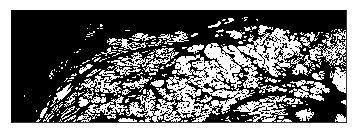

In [3]:
for matrix in confusion_matrices:
    print(matrix["Path Mask RGB"])
    #img = plt.imread(matrix["Path Mask RGB"])
    #misc.show_img(img)

    img = 255-(255*plt.imread(matrix["Path Mask RGB"])[:,:,0]).astype(np.uint8)
    misc.show_img(img)
    matrix["Mask RGB"] = img.copy()

In [4]:
colorize_each_fold = False
colorize_all_folds = False

for matrix in confusion_matrices:
    
    for prop in matrix["Properties To Analyze"]:
        table_prop_norm, c = func.get_table_properties(matrix["Graph"], prop["Properties Names"], True)
        prop["Table of Properites Normalized"] = table_prop_norm
        prop["Classes"] = c
        
        
        list_test_index = []
        list_classes_pred = []
        
        N = len(matrix["Health Nodes"]) + len(matrix["Unhealth Nodes"])
        
        fold_idx = 0
        for data_train, classes_train, data_test, classes_test, test_indices in get_fold(table_prop_norm, c, prop["Number of Folds"]):
            fold_idx += 1
            list_test_index.extend(test_indices)

            # Train classifier using data_train, classes_train
            mpl = MLPClassifier(hidden_layer_sizes=[80], solver='lbfgs', alpha=0.0001, learning_rate_init=0.001)
            mpl.fit(data_train, classes_train)

            # Test classifier using data_test, classes_test
            pred = mpl.predict(data_test)
            list_classes_pred.append(pred)

            # Save predictions
            prop["Classes Predicted"][test_indices] = pred
            prop["Tested Indexes"] = list_test_index
            #prop["Tested Indexes"] = list(test_indices)
            
            if colorize_each_fold:
                fold_position, fold_class_colors, fold_confusion_matrix = func.get_colors_by_pred_results_test_indices(matrix["Graph"], prop["Classes Predicted"], list(test_indices))
                fold_colorized_img = func.color_objects(matrix["Mask RGB"], fold_position, fold_class_colors, print_progress=True)

                plt.figure(figsize=(40,15))
                plt.imshow(fold_colorized_img)
                plt.axis('off')
                plt.savefig(matrix["Path"] + 'results_colorize_' + str(prop["Properties Index"]) + '/_fold_' + str(fold_idx) + '_img_colorized_all_glands.png', dpi=300)
                print(matrix["Path"] + 'results_colorize_' + str(prop["Properties Index"]) + '/_fold_' + str(fold_idx) + '_img_colorized_all_glands.png')

                fold_colorized_img[fold_colorized_img==0] = 255

                plt.figure(figsize=(40,15))
                plt.imshow(fold_colorized_img)
                plt.axis('off')
                plt.savefig(matrix["Path"] + 'results_colorize_' + str(prop["Properties Index"]) + '/_fold_' + str(fold_idx) + '_img_colorized_all_glands_w.png', dpi=300)
                print(matrix["Path"] + 'results_colorize_' + str(prop["Properties Index"]) + '/_fold_' + str(fold_idx) + '_img_colorized_all_glands_w.png')
                    
        
        if colorize_all_folds and prop["Properties Index"] == 3:
            fold_position, fold_class_colors, fold_confusion_matrix = func.get_colors_by_pred_results_test_indices(matrix["Graph"], prop["Classes Predicted"], prop["Tested Indexes"])
            fold_colorized_img = func.color_objects(matrix["Mask RGB"], fold_position, fold_class_colors, print_progress=True)

            plt.figure(figsize=(40,15))
            plt.imshow(fold_colorized_img)
            plt.axis('off')
            plt.savefig(matrix["Path"] + 'results_colorize_' + str(prop["Properties Index"]) + '/img_colorized_all_glands.png', dpi=300)
            print(matrix["Path"] + 'results_colorize_' + str(prop["Properties Index"]) + '/img_colorized_all_glands.png')

            fold_colorized_img[fold_colorized_img==0] = 255

            plt.figure(figsize=(40,15))
            plt.imshow(fold_colorized_img)
            plt.axis('off')
            plt.savefig(matrix["Path"] + 'results_colorize_' + str(prop["Properties Index"]) + '/img_colorized_all_glands_w.png', dpi=300)
            print(matrix["Path"] + 'results_colorize_' + str(prop["Properties Index"]) + '/img_colorized_all_glands_w.png')
                
            
        # `pred_classes` can then be compared with `classes` for verifying the accuracy of the classifier
        prop["Accuracy"] = np.sum(c==prop["Classes Predicted"])/N
        print("%3.4f" % (np.sum(c==prop["Classes Predicted"])/N) + " Accuracy of \"" + matrix["Image Name"] + "\" " + prop["Properties Description"])

0.6350 Accuracy of "3" Shapes
0.9163 Accuracy of "3" Network
0.9191 Accuracy of "3" All
0.9225 Accuracy of "3" Network Degree
0.6109 Accuracy of "S07_40805_upper_10X_Snapshot_20151028_54_region_01" Shapes
0.8431 Accuracy of "S07_40805_upper_10X_Snapshot_20151028_54_region_01" Network
0.8470 Accuracy of "S07_40805_upper_10X_Snapshot_20151028_54_region_01" All
0.8327 Accuracy of "S07_40805_upper_10X_Snapshot_20151028_54_region_01" Network Degree
0.6622 Accuracy of "S07_41755_upper_10X_Snapshot_20151028_44_region_02" Shapes
0.8784 Accuracy of "S07_41755_upper_10X_Snapshot_20151028_44_region_02" Network
0.8784 Accuracy of "S07_41755_upper_10X_Snapshot_20151028_44_region_02" All
0.8874 Accuracy of "S07_41755_upper_10X_Snapshot_20151028_44_region_02" Network Degree
0.6987 Accuracy of "S07_41755_upper_10X_Snapshot_20151028_44_region_03" Shapes
0.9519 Accuracy of "S07_41755_upper_10X_Snapshot_20151028_44_region_03" Network
0.9679 Accuracy of "S07_41755_upper_10X_Snapshot_20151028_44_region_03"

# Colorize Classes

In [ ]:
for matrix in confusion_matrices:
    # Get Color objects color GREEN (not demarcated) and color RED (demarcated) otherwise ORANGE(undefined)
    position, class_colors, measurements = func.get_color_inputs(matrix["Graph"])

    # Get Color objects according to the colors defined in `class_colors`
    img_colored1 = func.color_objects(img, position, class_colors, print_progress=True)

    #remove black in background
    img_colored1[img_colored1==0] = 255
    
    plt.figure(figsize=(40,15))
    plt.imshow(img_colored1)
    plt.axis('off')
    plt.savefig(matrix["Path Result Class Color"], dpi=300)

# Colorize Results in each properties group

In [5]:
colorize_results = False
colorize_cross_measurements = False
colorize_network_prop = 'Network Betweenness'
idx = 0
for matrix in confusion_matrices:
    
    print("------")
    print(matrix["Image Name"])
    
    for prop in matrix["Properties To Analyze"]:
        position, class_colors, confusion_matrix = func.get_colors_by_pred_results_test_indices(matrix["Graph"], prop["Classes Predicted"], prop["Tested Indexes"])
        print('----------------------------------------------')
        print("{:3.4f} % Accuracy with ".format(prop["Accuracy"]) + prop["Properties Description"])
        print('----------------------------------------------')
        print('         +---------------------------------+')
        print('         |  Health Class  | Unhealth Class |')
        print('         +---------------------------------+')
        print('  Health |      ' + "{:04d}".format(confusion_matrix[0][0]) + '      |       ' + "{:04d}".format(confusion_matrix[0][1]) + '     |')
        print('         +---------------------------------+')
        print('Unhealth |      ' + "{:04d}".format(confusion_matrix[1][0]) + '      |       ' + "{:04d}".format(confusion_matrix[1][1]) + '     |')
        print('         +---------------------------------+')
        
        tn = confusion_matrix[0][0]
        fp = confusion_matrix[0][1]
        fn = confusion_matrix[1][0]
        tp = confusion_matrix[1][1]

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        true_negative_rate = tn / (tn + fp)
        accuracy = (tp + tn) / (tp + tn + fp + fn)

        print('Precision: ' + "{:3.4f}".format(precision))
        print('Recall: ' + "{:3.4f}".format(recall))
        print('Specificity: ' + "{:3.4f}".format(true_negative_rate))
        print('Accuracy: ' + "{:3.4f}".format(accuracy))
        
        prop["Confusion Matrix"]["Data"] = confusion_matrix.copy()
        prop["Confusion Matrix"]["Precision"] = precision
        prop["Confusion Matrix"]["Recall"] = recall
        prop["Confusion Matrix"]["Specificity"] = true_negative_rate
        prop["Confusion Matrix"]["Accuracy"] = accuracy
        
        print("")
        print("")
        
        
        if colorize_results:
            colorized_img = func.color_objects(matrix["Mask RGB"], position, class_colors, print_progress=False)

            plt.figure(figsize=(40,15))
            plt.imshow(colorized_img)
            plt.axis('off')
            plt.savefig(matrix["Path"] + 'results_colorize_' + str(prop["Properties Index"]) + '/img_colorized_all_glands.png', dpi=300)

            colorized_img[colorized_img==0] = 255

            plt.figure(figsize=(40,15))
            plt.imshow(colorized_img)
            plt.axis('off')
            plt.savefig(matrix["Path"] + 'results_colorize_' + str(prop["Properties Index"]) + '/img_colorized_all_glands_w.png', dpi=300)
        
        
        if colorize_cross_measurements and prop["Properties Description"]==colorize_network_prop:
            position, class_colors, measurements = func.get_color_inputs(matrix["Graph"], measurment_prop=prop["Properties Names"][0])
            colored_cross = func.color_objects(img, position, values=measurements, colormap='viridis', print_progress=True)

            plt.figure(figsize=(30,15))
            plt.imshow(colored_cross)
            cbar = plt.colorbar()
            cbar.set_label(prop["Properties Names"][0], size=16)
            cbar.ax.tick_params(labelsize=14)
            plt.axis('off')
            plt.savefig(matrix["Path"] + 'results_colorize_' + str(prop["Properties Index"]) + '/img_colored_cross_measurements_' + prop["Properties Names"][0] + '.png', dpi=300)

            #remove black in background
            colored_cross[colored_cross==0] = 255

            plt.figure(figsize=(30,15))
            plt.imshow(colored_cross)
            cbar = plt.colorbar()
            cbar.set_label(prop["Properties Description"], size=16)
            cbar.ax.tick_params(labelsize=14)
            plt.axis('off')
            plt.savefig(matrix["Path"] + 'results_colorize_' + str(prop["Properties Index"]) + '/img_colored_cross_measurements_' + prop["Properties Names"][0] + '_w.png', dpi=300)
        
    print("")
    print("")

------
3
----------------------------------------------
0.6350 % Accuracy with Shapes
----------------------------------------------
         +---------------------------------+
         |  Health Class  | Unhealth Class |
         +---------------------------------+
  Health |      1119      |       0669     |
         +---------------------------------+
Unhealth |      0103      |       0224     |
         +---------------------------------+
Precision: 0.2508
Recall: 0.6850
Specificity: 0.6258
Accuracy: 0.6350


----------------------------------------------
0.9163 % Accuracy with Network
----------------------------------------------
         +---------------------------------+
         |  Health Class  | Unhealth Class |
         +---------------------------------+
  Health |      1627      |       0161     |
         +---------------------------------+
Unhealth |      0016      |       0311     |
         +---------------------------------+
Precision: 0.6589
Recall: 0.9511
Specifi

         +---------------------------------+
         |  Health Class  | Unhealth Class |
         +---------------------------------+
  Health |      0248      |       0014     |
         +---------------------------------+
Unhealth |      0047      |       0245     |
         +---------------------------------+
Precision: 0.9459
Recall: 0.8390
Specificity: 0.9466
Accuracy: 0.8899




------
S07_42991_lower_10X_Snapshot_20151028_47_region_08
----------------------------------------------
0.5724 % Accuracy with Shapes
----------------------------------------------
         +---------------------------------+
         |  Health Class  | Unhealth Class |
         +---------------------------------+
  Health |      0052      |       0033     |
         +---------------------------------+
Unhealth |      0029      |       0031     |
         +---------------------------------+
Precision: 0.4844
Recall: 0.5167
Specificity: 0.6118
Accuracy: 0.5724


------------------------------------------

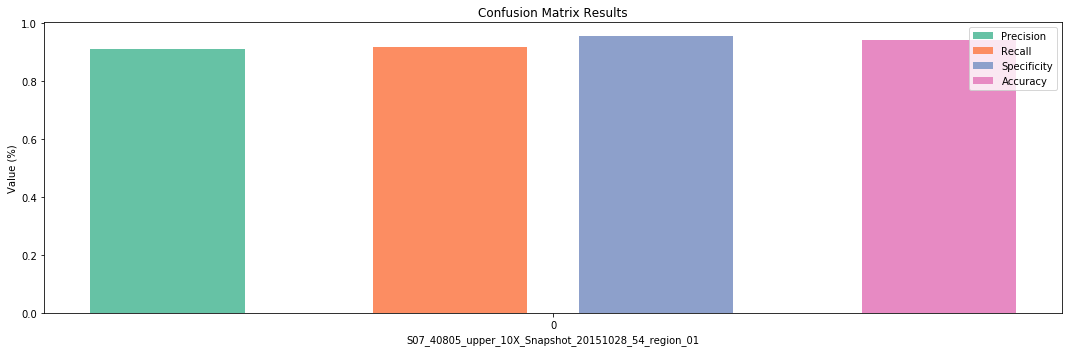

In [6]:
x = np.arange(1)  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(15,5))

rects3 = ax.bar(x - (2.5*width), precision, width, label='Precision', color= ( np.array((102,194,165)) / 255 ) )
rects1 = ax.bar(x - width/1.5, recall, width, label='Recall', color= ( np.array((252,141,98)) / 255 ))

rects2 = ax.bar(x + width/1.5, true_negative_rate, width, label='Specificity', color= ( np.array((141,160,203)) / 255 ))
rects4 = ax.bar(x + (2.5*width), accuracy, width, label='Accuracy', color= ( np.array((231,138,195)) / 255 ))


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value (%)')
ax.set_title('Confusion Matrix Results')
ax.set_xticks(x)
ax.set_xlabel(confusion_matrices[1]["Image Name"])
ax.legend()


fig.tight_layout()

plt.savefig(confusion_matrices[1]["Path"] + 'confusion_matrix.png', dpi=300)
plt.show()



In [7]:
data_confusion_matrix = {}
for p in ["Shapes", "Network", "All", "Network Degree"]:
    data_confusion_matrix[p] = { 
            "Precision": [],
            "Recall": [],
            "Specificity": [],
            "Accuracy": []
        }

for matrix in confusion_matrices:
    
    img_name    = confusion_matrices[0]["Image Name"]
    
    i = 1
    
    for prop in matrix["Properties To Analyze"]:
        data_cm = data_confusion_matrix[prop["Properties Description"]]
        
        data_cm["Precision"].append( prop["Confusion Matrix"]["Precision"] )
        data_cm["Recall"].append( prop["Confusion Matrix"]["Recall"] )
        data_cm["Specificity"].append( prop["Confusion Matrix"]["Specificity"] )
        data_cm["Accuracy"].append( prop["Confusion Matrix"]["Accuracy"] )


print(data_confusion_matrix)


{'Shapes': {'Precision': [0.25083986562150057, 0.8411633109619687, 0.7925925925925926, 0.7607361963190185, 0.6269230769230769, 0.484375, 0.4824462061155153], 'Recall': [0.6850152905198776, 0.6214876033057851, 0.6948051948051948, 0.6927374301675978, 0.5582191780821918, 0.5166666666666667, 0.7580071174377224], 'Specificity': [0.6258389261744967, 0.572289156626506, 0.5882352941176471, 0.706766917293233, 0.6297709923664122, 0.611764705882353, 0.5919642857142857], 'Accuracy': [0.6349881796690308, 0.6108949416342413, 0.6621621621621622, 0.6987179487179487, 0.592057761732852, 0.5724137931034483, 0.6474435196195006]}, 'Network': {'Precision': [0.6588983050847458, 0.9689922480620154, 0.9440559440559441, 0.9712643678160919, 0.8941605839416058, 0.864406779661017, 0.900523560209424], 'Recall': [0.9510703363914373, 0.8264462809917356, 0.8766233766233766, 0.9441340782122905, 0.839041095890411, 0.85, 0.9181494661921709], 'Specificity': [0.9099552572706935, 0.9036144578313253, 0.8823529411764706, 0.96

[Text(0,0,'Precision'),
 Text(0,0,'Recall'),
 Text(0,0,'Specificity'),
 Text(0,0,'Accuracy')]

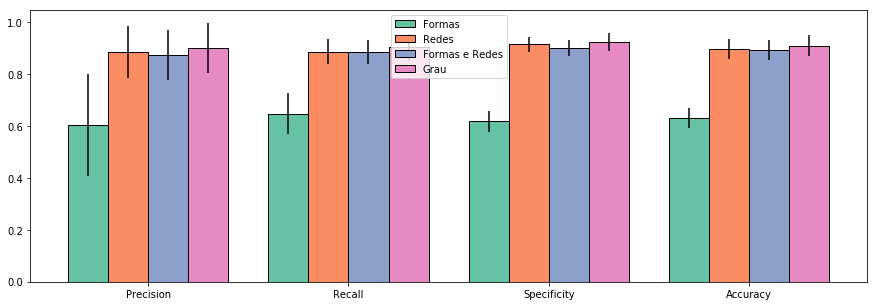

In [8]:
dx = 0.1 #distance between each set of 4 bars, wich is 2 * dx
bw = (1 - 2 * dx) / 4 # width of each bin
bw2 = bw / 2

colors = [np.array((102,194,165)) / 255, np.array((252,141,98)) / 255, 
        np.array((141,160,203)) / 255, np.array((231,138,195)) / 255]

fig, ax = plt.subplots(figsize=(15,5))

for meas_idx, (meas_keys, meas_values) in enumerate(data_confusion_matrix.items()):
    for perf_idx, (perf_keys, perf_values) in enumerate(meas_values.items()):
        
        avg = np.mean(perf_values)
        std_dev = np.std(perf_values)
        
        if perf_idx == 0:
            label = meas_keys
        else:
            label = None
        
        if label == 'Shapes':
            label = 'Formas'
        elif label == 'Network':
            label = 'Redes'
        elif label == 'All':
            label = 'Formas e Redes'
        elif label == 'Network Degree':
            label = 'Grau'
            
        x = perf_idx + dx + bw2 + meas_idx * bw
        bar = plt.bar(x, avg, yerr=std_dev, width = bw, label = label, color = colors[meas_idx], edgecolor = 'k')

plt.legend()
ax.set_xticks(np.arange(.5, 4, 1))
ax.set_xticklabels(list( list(data_confusion_matrix.values())[0].keys() ))

In [9]:
for meas_idx, (meas_keys, meas_values) in enumerate(data_confusion_matrix.items()):
    print(meas_keys)
    print('Accuracy' + str(meas_values['Accuracy']))
    print('Images' + str(image_names))
    print('Avg[' + str(np.mean(meas_values['Accuracy'])) + ']')
    print('StdDev[' + str(np.std(meas_values['Accuracy'])) + ']')
    print('----')
    print('Precision' + str(meas_values['Precision']))
    print('Images' + str(image_names))
    print('Avg[' + str(np.mean(meas_values['Precision'])) + ']')
    print('StdDev[' + str(np.std(meas_values['Precision'])) + ']')
    print('----')
    print('Recall' + str(meas_values['Recall']))
    print('Images' + str(image_names))
    print('Avg[' + str(np.mean(meas_values['Recall'])) + ']')
    print('StdDev[' + str(np.std(meas_values['Recall'])) + ']')
    print('----')
    print('Specificity' + str(meas_values['Specificity']))
    print('Images' + str(image_names))
    print('Avg[' + str(np.mean(meas_values['Specificity'])) + ']')
    print('StdDev[' + str(np.std(meas_values['Specificity'])) + ']')
    print('----')
        
    print('')
    print('')
    print('')
    print('')

Shapes
Accuracy[0.6349881796690308, 0.6108949416342413, 0.6621621621621622, 0.6987179487179487, 0.592057761732852, 0.5724137931034483, 0.6474435196195006]
Images['3', 'S07_40805_upper_10X_Snapshot_20151028_54_region_01', 'S07_41755_upper_10X_Snapshot_20151028_44_region_02', 'S07_41755_upper_10X_Snapshot_20151028_44_region_03', 'S07_41755_upper_10X_Snapshot_20151028_44_region_04', 'S07_42991_lower_10X_Snapshot_20151028_47_region_08', 'S07_46186 10X_20151028_59']
Avg[0.6312397580913119]
StdDev[0.03999240711472973]
----
Precision[0.25083986562150057, 0.8411633109619687, 0.7925925925925926, 0.7607361963190185, 0.6269230769230769, 0.484375, 0.4824462061155153]
Images['3', 'S07_40805_upper_10X_Snapshot_20151028_54_region_01', 'S07_41755_upper_10X_Snapshot_20151028_44_region_02', 'S07_41755_upper_10X_Snapshot_20151028_44_region_03', 'S07_41755_upper_10X_Snapshot_20151028_44_region_04', 'S07_42991_lower_10X_Snapshot_20151028_47_region_08', 'S07_46186 10X_20151028_59']
Avg[0.605582321219096]
St

In [10]:
print_results = False

img_names = []
y_health_nodes = []
y_unhealth_nodes = []
y_accuracy = []
y_precision = []
y_recall = []
y_specificity = []

plot_prop = ["Shapes", "Network", "All", "Network Degree"]
prop_idx = 2

for matrix in confusion_matrices:
    img_names.append(matrix["Image Name"])
    y_health_nodes.append(len(matrix["Health Nodes"]))
    y_unhealth_nodes.append(len(matrix["Unhealth Nodes"]))
    
    if print_results:
        print(matrix["Image Name"])
        print("Health Nodes: " + str(len(matrix["Health Nodes"])))
        print("Unhealth Nodes: " + str(len(matrix["Unhealth Nodes"])))
    
        
    for prop in matrix["Properties To Analyze"]:
        if prop["Properties Description"] == plot_prop[prop_idx]:
            y_accuracy.append(prop["Confusion Matrix"]["Accuracy"])
            y_precision.append(prop["Confusion Matrix"]["Precision"])
            y_recall.append(prop["Confusion Matrix"]["Recall"])
            y_specificity.append(prop["Confusion Matrix"]["Specificity"])


        if print_results:
            print(str(prop["Properties Names"]))
            print('Accuracy: ' + str(prop["Confusion Matrix"]["Accuracy"]))
            print('Precision: ' + str(prop["Confusion Matrix"]["Precision"]))
            print('Recall: ' + str(prop["Confusion Matrix"]["Recall"]))
            print('Specificity: ' + str(prop["Confusion Matrix"]["Specificity"]))

            print('')
            print('----------')
            print('')
    
    if print_results:   
        print('')
        print('--------------------------------')
        print('--------------------------------')
        print('')

        print('')

ValueError: x and y must have same first dimension, but have shapes (12,) and (7,)

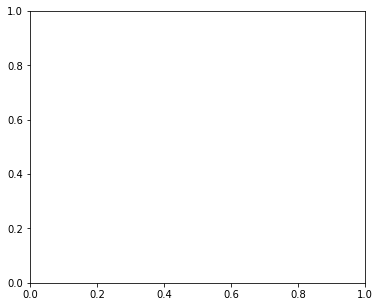

In [11]:
y_total_glands = np.array(y_health_nodes) + np.array(y_unhealth_nodes)
y_total_glands = y_total_glands / y_total_glands[0]
    
    
fig = plt.figure(figsize=(6, 5))

#plt.plot(x_iterations, y_health_nodes, label = "Health Glands")
#plt.plot(x_iterations, y_unhealth_nodes, label = "Unhealth Glands")
plt.plot(x_iterations, y_total_glands, label = "Total Glands")
 
plt.xlabel('Iterations')
plt.ylabel('Relative Glands Quantity')

plt.locator_params(axis='x', nbins=5)

plt.legend()

if erode:
    plt.savefig('prostate_marked/glands_erode.pdf', dpi=300)
if dilate:
    plt.savefig('prostate_marked/glands_dilate.pdf', dpi=300)
if dilate_no_merge:
    plt.savefig('prostate_marked/glands_dilate_no_merge.pdf', dpi=300)
if remove_randomly:
    plt.savefig('prostate_marked/glands_remove_randomly.pdf', dpi=300)

In [ ]:
# RANDOMLY REMOVE GLANDS
if remove_randomly:
    y_total_glands = np.array(y_health_nodes) + np.array(y_unhealth_nodes)
    y_total_glands = y_total_glands / y_total_glands[0]

    fig = plt.figure(figsize=(6, 5))

    plt.plot(x_iterations, y_accuracy, label = "Accuracy")
    plt.plot(x_iterations, y_precision, label = "Precision")
    plt.plot(x_iterations, y_recall, label = "Recall")
    plt.plot(x_iterations, y_specificity, label = "Specificity")

    plt.locator_params(axis='x', nbins=5)

    plt.xlabel('Percentage of glands removed')
    plt.ylabel('Performance')
  
    plt.legend()

    plt.ylim((0,1.1))

    plt.savefig('prostate_marked/results_randomly_removed.pdf', dpi=300)

In [ ]:
if erode:
    y_total_glands = np.array(y_health_nodes) + np.array(y_unhealth_nodes)
    y_total_glands = y_total_glands / y_total_glands[0]

    fig = plt.figure(figsize=(6, 5))

    plt.plot(x_iterations, y_accuracy, label = "Accuracy")
    plt.plot(x_iterations, y_precision, label = "Precision")
    plt.plot(x_iterations, y_recall, label = "Recall")
    plt.plot(x_iterations, y_specificity, label = "Specificity")
    plt.plot(x_iterations, y_total_glands,"--", label = "Relative Number of Glands", )

    plt.locator_params(axis='x', nbins=5)

    plt.xlabel('Erosion amount')
    plt.ylabel('Performance')

    plt.legend()

    plt.ylim((0,1.1))

    plt.savefig('prostate_marked/results_erosion.pdf', dpi=300)

In [ ]:
if dilate:
    y_total_glands = np.array(y_health_nodes) + np.array(y_unhealth_nodes)
    y_total_glands = y_total_glands / y_total_glands[0]

    fig = plt.figure(figsize=(6, 5))

    plt.plot(x_iterations, y_accuracy, label = "Accuracy")
    plt.plot(x_iterations, y_precision, label = "Precision")
    plt.plot(x_iterations, y_recall, label = "Recall")
    plt.plot(x_iterations, y_specificity, label = "Specificity")
    plt.plot(x_iterations, y_total_glands,"--", label = "Relative Number of Glands", )

    plt.locator_params(axis='x', nbins=5)

    plt.xlabel('Dilation amount')
    plt.ylabel('Performance')

    plt.ylim((0,1.1))

    plt.legend()

    plt.savefig('prostate_marked/results_dilation.pdf', dpi=300)

In [ ]:
if dilate_no_merge:
    y_total_glands = np.array(y_health_nodes) + np.array(y_unhealth_nodes)
    y_total_glands = y_total_glands / y_total_glands[0]

    fig = plt.figure(figsize=(6, 5))

    plt.plot(x_iterations, y_accuracy, label = "Accuracy")
    plt.plot(x_iterations, y_precision, label = "Precision")
    plt.plot(x_iterations, y_recall, label = "Recall")
    plt.plot(x_iterations, y_specificity, label = "Specificity")
    plt.plot(x_iterations, y_total_glands,"--", label = "Relative Number of Glands", )

    plt.locator_params(axis='x', nbins=5)

    plt.xlabel('Dilation amount')
    plt.ylabel('Performance')

    plt.legend()

    plt.savefig('prostate_marked/results_dilation_no_merge.pdf', dpi=300)